In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim 
import skillsnetwork 

In [ ]:
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "/home/bruno/DeepLearning_PyTorch", overwrite=True)

In [54]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/bruno/DeepLearning_PyTorch"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:10000] #Change to 30000 to use the full test dataset
            self.Y=self.Y[0:10000] #Change to 30000 to use the full test dataset
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [55]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [56]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [74]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

In [75]:
image_tensor = torch.randn(3, 32, 32)

In [76]:
print(image_tensor.shape)

torch.Size([3, 32, 32])


In [71]:
a = type(dataset_train[0][0].numpy())

In [79]:
dataset_train[0][0].permute(1, 2, 0).numpy()

array([[[0.10831413, 0.3102242 , 0.5484969 ],
        [0.12543888, 0.3277312 , 0.56592613],
        [0.17681314, 0.3802522 , 0.6182137 ],
        ...,
        [0.24531215, 0.41526622, 0.6182137 ],
        [0.24531215, 0.41526622, 0.6182137 ],
        [0.24531215, 0.41526622, 0.6182137 ]],

       [[0.14256364, 0.3452382 , 0.5833553 ],
        [0.15968838, 0.3627452 , 0.6007845 ],
        [0.17681314, 0.3802522 , 0.6182137 ],
        ...,
        [0.24531215, 0.41526622, 0.6182137 ],
        [0.24531215, 0.41526622, 0.6182137 ],
        [0.24531215, 0.41526622, 0.6182137 ]],

       [[0.21106265, 0.41526622, 0.65307206],
        [0.1939379 , 0.3977592 , 0.6356429 ],
        [0.1939379 , 0.3977592 , 0.6356429 ],
        ...,
        [0.24531215, 0.41526622, 0.6182137 ],
        [0.24531215, 0.41526622, 0.6182137 ],
        [0.24531215, 0.41526622, 0.6182137 ]],

       ...,

       [[0.2281874 , 0.3802522 , 0.6356429 ],
        [0.24531215, 0.3977592 , 0.65307206],
        [0.24531215, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


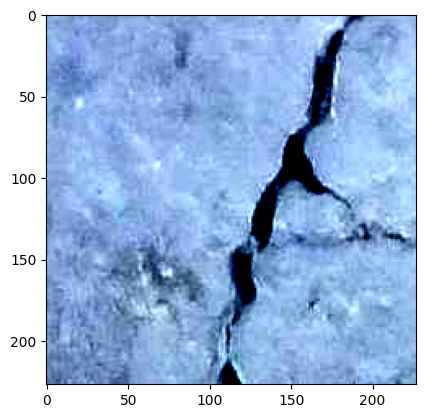

In [84]:
plt.imshow(dataset_train[2][0].permute(1, 2, 0).numpy())

In [8]:
size_of_image=3*227*227
size_of_image

154587

In [9]:
torch.manual_seed(0)

In [96]:
class SoftMax(nn.Module):
    def __init__(self, number_inputs, number_outputs=2):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(number_inputs, number_outputs)

    
    def forward(self, x):
        x = self.linear(x)

        return x

In [97]:
model = SoftMax(number_inputs=size_of_image, number_outputs=2)

In [98]:
torch.cuda.is_available()
device = torch.device('cuda:0')
model.to(device)

SoftMax(
  (linear): Linear(in_features=154587, out_features=2, bias=True)
)

In [99]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)

In [100]:
criterion = nn.CrossEntropyLoss()

In [101]:
data_train = DataLoader(dataset_train, batch_size = 5)
data_val = DataLoader(dataset_val, batch_size = 5)

In [102]:
epochs = 5
LOSS_TRAIN = []
correct = 0
ACCURACY = []
print("Training has begun\n")
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for x, y in data_train:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        model_train = model(x.view(-1, size_of_image))
        loss = criterion(model_train, y)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_train = running_loss / len(dataset_train)
    LOSS_TRAIN.append(loss_train)
    
    with torch.no_grad():
        model.eval()
        correct = 0
        count = 0
        for x_val, y_val in data_val:
            x_val, y_val = x_val.to(device), y_val.to(device)
            #print(y_val)
            model_val = model(x_val.view(-1, size_of_image))
            value, prediction = torch.max(model_val, 1)
            correct += (prediction==y_val).sum().item()
            count += 1
            
        #print(count)  
        accuracy = correct / len(dataset_val)

    # with torch.no_grad():
    #     model.eval()
    #     correct = 0
    #     count = 0
    #     for x_train, y_train in data_train:
    #         x_train, y_train = x_train.to(device), y_train.to(device)
    #         #print(y_val)
    #         model_test = model(x_train.view(-1, size_of_image))
    #         value, prediction = torch.max(model_test, 1)
    #         correct += (prediction==y_train).sum().item()
    #         count += 1
            
    #     #print(count)  
    #     accuracy_train = correct / len(dataset_train)
        
    ACCURACY.append(accuracy)
    
    print("Epoch: ", epoch + 1, "Train Loss: ", loss_train, "Accuracy Training Data: ", "Accuracy: ", accuracy)

Training has begun

Epoch:  1 Train Loss:  197.06421191566213 Accuracy Training Data:  Accuracy:  0.6298
Epoch:  2 Train Loss:  133.99779996068105 Accuracy Training Data:  Accuracy:  0.6779
Epoch:  3 Train Loss:  127.83434720001097 Accuracy Training Data:  Accuracy:  0.8219
Epoch:  4 Train Loss:  113.61249526684732 Accuracy Training Data:  Accuracy:  0.8094
Epoch:  5 Train Loss:  112.00490415651305 Accuracy Training Data:  Accuracy:  0.8344


In [103]:
prediction

tensor([0, 1, 0, 1, 0], device='cuda:0')

In [104]:
model_val.shape

torch.Size([5, 2])

In [105]:
print((prediction==y_val).sum().item())

5


In [106]:
len(dataset_val)

10000

In [107]:
test = model(dataset_train[0][0].to(device).view(-1,size_of_image))
print(test.shape)
v, p = torch.max(test,1)
print(p)

torch.Size([1, 2])
tensor([1], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


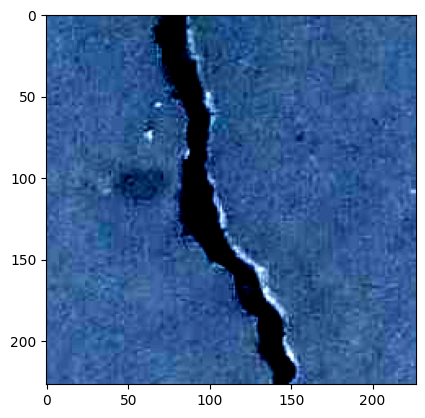

In [108]:
plt.imshow(dataset_train[0][0].permute(1, 2, 0).numpy())

In [109]:
print(test)

tensor([[-7989.5513,  7990.0439]], device='cuda:0', grad_fn=<AddmmBackward0>)
